In [1]:
library(velocyto.R)
library(ggplot2)
source("../R/Seurat_functions.R")

Loading required package: Matrix


# 6.1 load seurat

In [2]:
lnames = load(file = "../data/DLBCL_8.Rda")
lnames

[1] "DLBCL"     "genes.use"

In [3]:
AllCells <- Seurat::WhichCells(DLBCL)
Cells_3119T1 <- AllCells[grepl("3119T1",AllCells)]
DLBCL_3119T1 <- Seurat::SubsetData(DLBCL, cells.use = Cells_3119T1)
DLBCL_3119T1

An object of class seurat in project EC-RW-4311 EC-RW-4311 EC-RW-4311 EC-RW-4311 EC-RW-4262 EC-RW-4262 EC-RW-4311 EC-RW-4311 
 20809 genes across 2726 samples.

# 6.2 Rename identities

In [4]:
idents <- as.data.frame(table(DLBCL_3119T1@ident))
old.ident.ids <- idents$Var1
new.cluster.ids <- c("B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "B cells",
                     "T & NK cells",
                     "B cells",
                     "T & NK cells",
                     "T & NK cells")
DLBCL_3119T1@ident <- plyr::mapvalues(x = DLBCL_3119T1@ident,
                                   from = old.ident.ids,
                                   to = new.cluster.ids)

# 6.3 Extract color code and TSNE embeddings

      colour
1    #F8766D
1517 #00BFC4


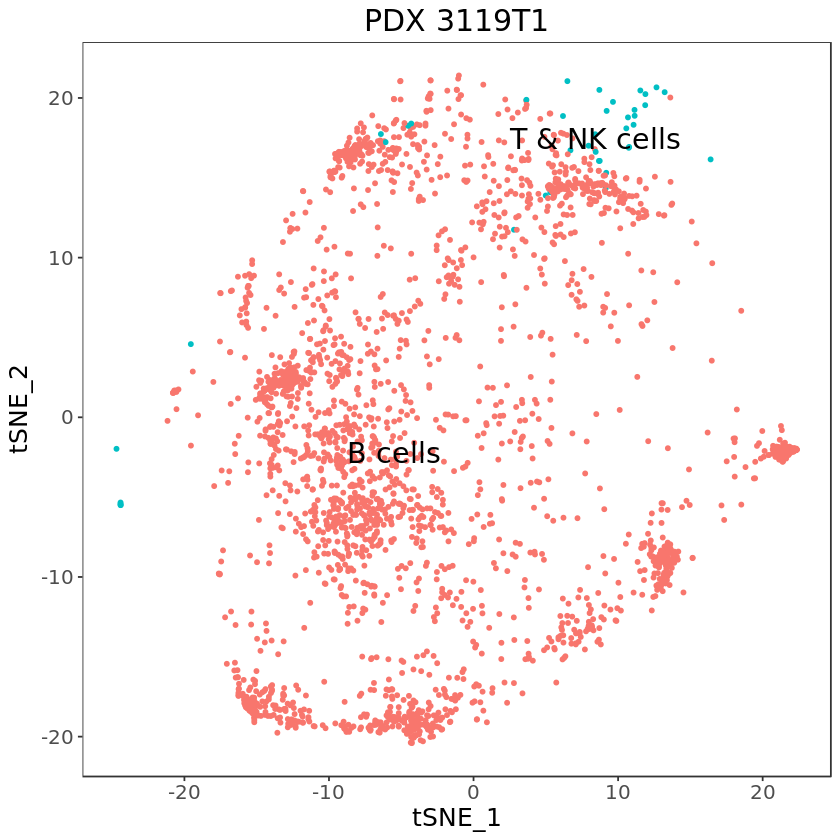

In [5]:
gg_colors <- function(object = DLBCL.PDX, no.legend = TRUE, do.label = TRUE,
                      do.return = TRUE, label.size = 6, gg_title=""){
        g1 <- Seurat::TSNEPlot(object = object, no.legend = no.legend,
                               do.label = do.label,do.return = do.return,
                               label.size = label.size)+
                ggtitle(gg_title)+
                theme(text = element_text(size=15),     #larger text including legend title							
                      plot.title = element_text(hjust = 0.5)) #title in middle
        print(g1)
        g <- ggplot2::ggplot_build(g1)
        print(unique(g$data[[1]]["colour"]))
        colors <- unlist(g$data[[1]]["colour"])
        cells <- Seurat::WhichCells(object)
        names(colors) <- stringi::stri_replace_last_fixed(cells,"_",":")
        names(colors) <- paste0(names(colors),"x")
        
        return(colors)
}
Colors_3119T1 <- gg_colors(object = DLBCL_3119T1, gg_title="PDX 3119T1")

In [6]:
DLBCL_3119T1_emb <- DLBCL_3119T1@dr$tsne@cell.embeddings[,1:2]
row.names(DLBCL_3119T1_emb) <- stringi::stri_replace_last_fixed(row.names(DLBCL_3119T1_emb),"_",":")
row.names(DLBCL_3119T1_emb) <- paste0(row.names(DLBCL_3119T1_emb),"x")
remove(DLBCL)
remove(DLBCL_3119T1)
GC() # Clean memory

# 6.4 load loom file

In [7]:
ldat  <- read.loom.matrices("../data/3119T1/velocyto/3119T1.loom")
cell.colors <- Colors_3119T1
emb <- DLBCL_3119T1_emb

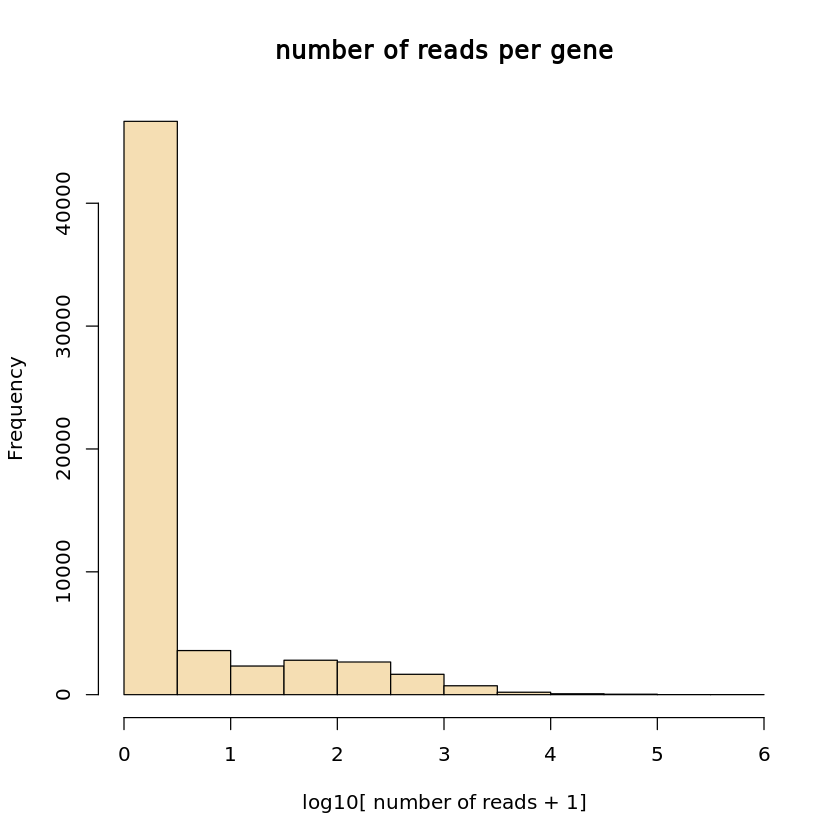

In [8]:
hist(log10(rowSums(ldat$spliced)+1),col='wheat',xlab='log10[ number of reads + 1]',
     main='number of reads per gene')

In [24]:
emat <- ldat$spliced # exonic read (spliced) expression matrix
nmat <- ldat$unspliced # intronic read (unspliced) expression matrix
smat <- ldat$ambiguous # spanning read (intron+exon) expression matrix
str(emat@Dim);str(nmat@Dim);str(smat@Dim)
# look at the resulting gene set
str(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

 int [1:2] 60736 2903
 int [1:2] 60736 2903
 int [1:2] 60736 2903
 chr [1:60576] "hg19_FAM138A" "hg19_RP11-34P13.7" "hg19_RP11-34P13.8" ...


In [25]:
# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 0.1)
nmat <- filter.genes.by.cluster.expression(nmat,cell.colors,min.max.cluster.average = 0.1)
smat <- filter.genes.by.cluster.expression(smat,cell.colors,min.max.cluster.average = 0.02)
str(emat@Dim);str(nmat@Dim);str(smat@Dim)
# look at the resulting gene set
str(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

 int [1:2] 3154 2903
 int [1:2] 3048 2903
 int [1:2] 2827 2903
 chr [1:581] "hg19_HP1BP3" "hg19_USP48" "hg19_HNRNPR" "hg19_SRSF4" ...


# 6.5 calculate gene-relative velocity

using k=5 cell kNN pooling, but now using entire range of expression to determine slope gamma,
and using spanning reads (smat) to fit the gene offsets.

In [26]:
rvel.qf <- gene.relative.velocity.estimates(emat,nmat,deltaT=1,kCells = 5,fit.quantile = 0.02)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 1119 genes
filtered out 555 out of 1119 genes due to low nmat-emat correlation
filtered out 86 out of 564 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


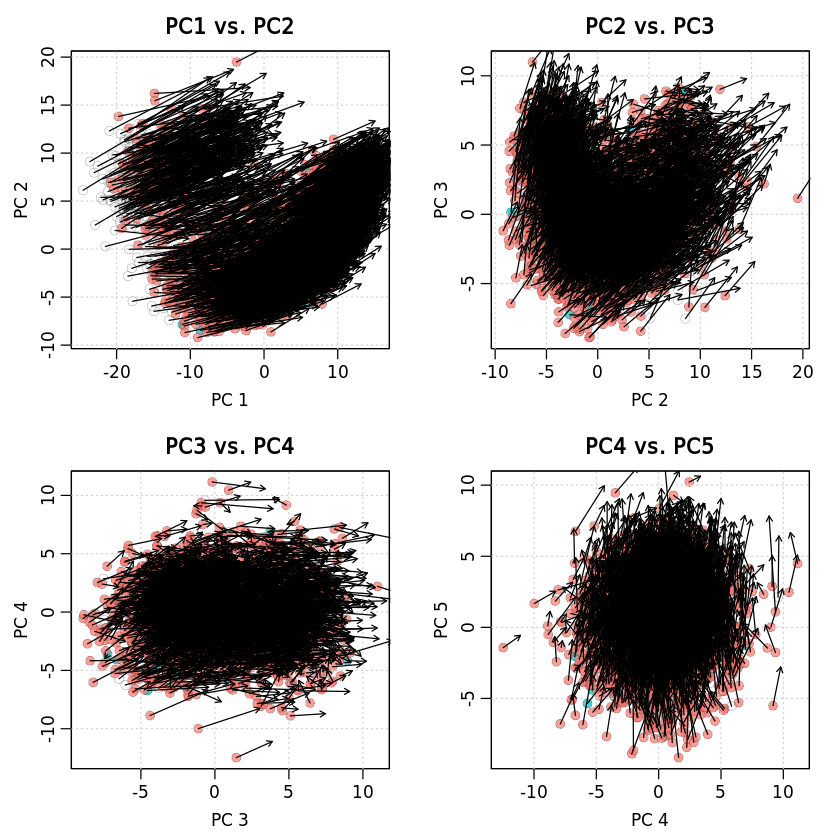

In [28]:
pca.velocity.plot(rvel.qf,nPcs=5,plot.cols=2,cell.colors=ac(cell.colors,alpha=0.7),
                  cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,-1,-1,-1))

# 6.6 define custom pallet for expression magnitude

calculating convolved matrices ... done


[1] 1

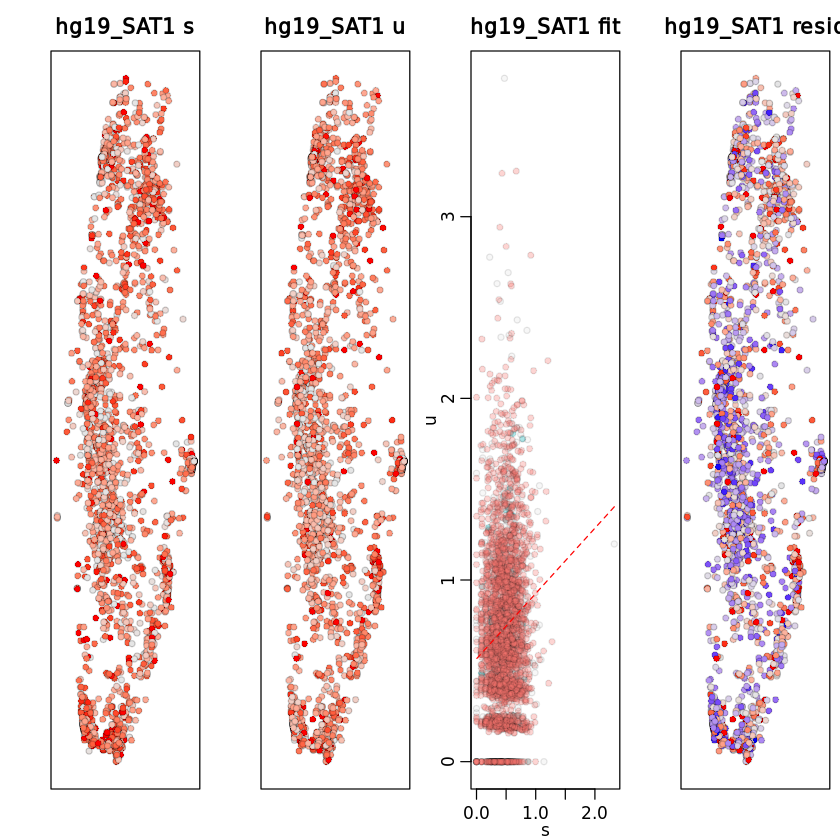

In [29]:
gene.relative.velocity.estimates(emat,nmat,deltaT=1,kCells = 5,fit.quantile = 0.02,old.fit=rvel.qf,
                                 show.gene='hg19_SAT1',cell.emb=emb,cell.colors=cell.colors)

# 6.7 Visualization on an existing embedding

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


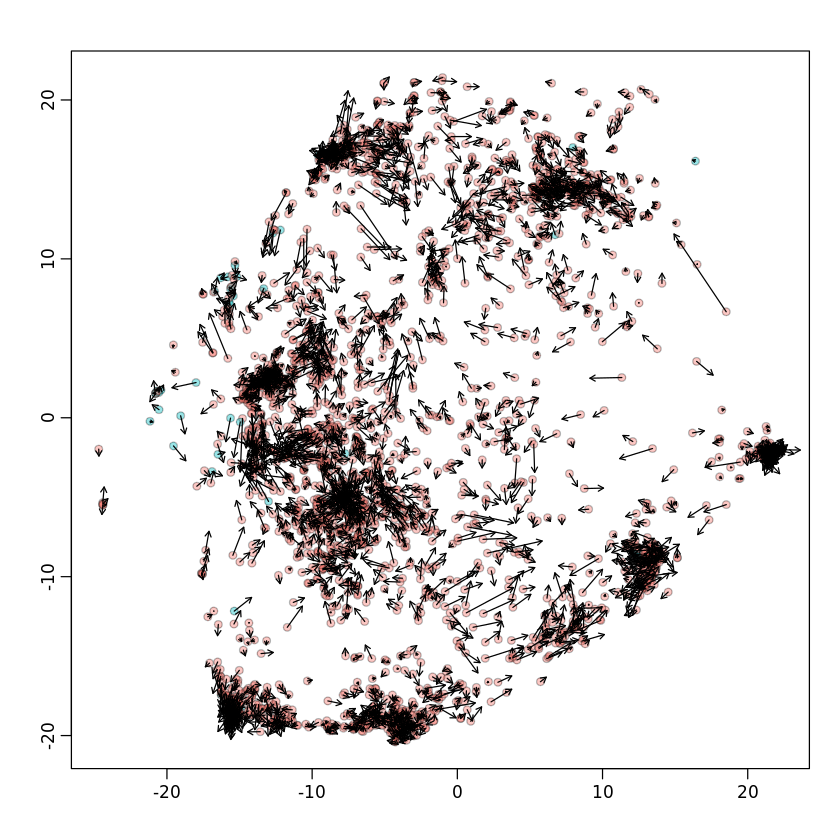

In [30]:
arrow.scale=6; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;
show.velocity.on.embedding.cor(emb,rvel.qf,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1)

Alternatively, the same function can be used to calculate a velocity vector field:

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... grid.sd= 1.684622  min.arrow.size= 0.03369243  max.grid.arrow.length= 0.1013337  done


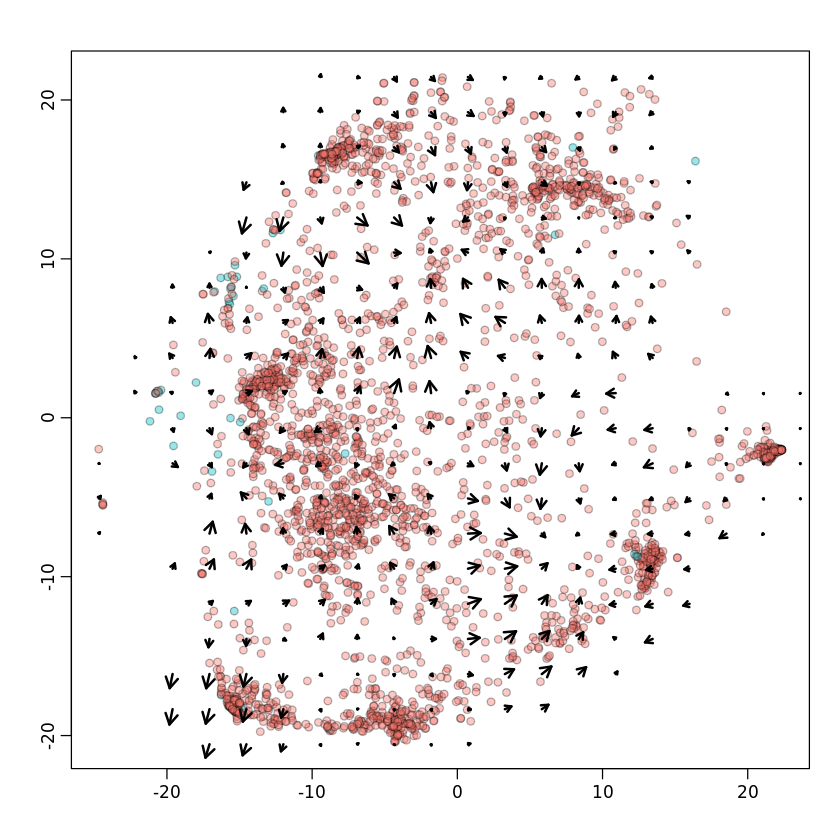

In [31]:
show.velocity.on.embedding.cor(emb,rvel.qf,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,show.grid.flow=TRUE,min.grid.cell.mass=0.5,
                               grid.n=20,arrow.lwd=2)